In [91]:
pip install scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/4b/48/20e77ddb1f473d4717a7d4d3fc8d15557f406f7708496054c59f635b7734/scipy-1.11.4-cp311-cp311-macosx_12_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 3.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import math 
from time import time
import numba as nb
import scipy.signal as signal

In [2]:
D_0 = 1.0
D_1 = 1e-2

L = 60
n = 60
scale = n // L

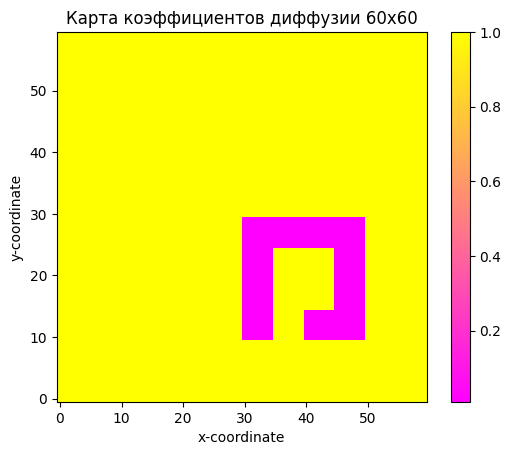

In [3]:
# Dij = np.full((n, n), D_0)

def MatrixD(n, D_0, D_1, scale):
    '''
    Функция для построения матрицы теплопроводности в зависимости от коэффициента диффузии с учетом ограничений в виде 
    включений белого цвета
    '''
    Dij = np.full((n, n), D_0)
    for i in range(25*scale, 30*scale):
        for j in range(30*scale, 50*scale ):
            Dij[i][j] = D_1

    for i in range(10*scale, 30*scale ):
        for j in range(30*scale, 35*scale):
            Dij[i][j] = D_1

    for i in range(10*scale, 15*scale ):
        for j in range(40*scale, 50*scale ):
            Dij[i][j] = D_1

    for i in range(10*scale, 30*scale ):
        for j in range(45*scale, 50*scale ):
            Dij[i][j] = D_1
            
    return Dij

plt.imshow(MatrixD(n, D_0, D_1, scale), cmap = 'spring')
plt.gca().invert_yaxis()
plt.title('Карта коэффициентов диффузии 60x60')
plt.colorbar()
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")


Dij = MatrixD(n, 1.0, 1e-2, scale)
# plt.imshow(Dij)
# plt.gca().invert_yaxis()
# plt.colorbar()


In [16]:
def period(arr):
    '''
    Функция для поиска периодов колебаний с помощью быстрого преобразования Фурье
    Функция недоработана. Надеюсь, что за такой прототип удастся набрать хоть немного баллов.
    При тестировании выдает ошибку 'list' object has no attribute 'find_peaks'
    '''
    signal = arr
    amplitudes = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal))
    peaks, _ = signal.find_peaks(amplitudes)
    periods = 1 / freqs[peaks]
    print("Периоды колебаний: ", periods)
    

In [12]:

dt = 0.005
from numba import njit, prange

dx = L / n


def diffuse_step_full(
    it: int,
    T: np.ndarray,
    dx: float,
    dt: float,
    Dij: np.ndarray
):
    ''' 
    Функция для рассчета тепла
    '''
    prev = it % 2
    cur  = prev - 1
    g = dt * Dij[1:-1, 1:-1] / dx**2
    
    T[cur, 1:-1, 1:-1] = T[prev, 1:-1, 1:-1] + g * (
        T[prev, 1:-1, 0:-2] + 
        T[prev, 1:-1, 2:  ] + 
        T[prev, 0:-2, 1:-1] + 
        T[prev, 2:,   1:-1] -
        4 * T[prev, 1:-1, 1:-1]
    )


@njit(parallel = True)
def diffuse_step_par(ti, T, Dij):
    ''' 
    Еще одна функция для рассчета тепла. Ее используем только при N = 60
    '''
    ti = ti % 2
    tj = (ti + 1) % 2
    
    for i in prange(1, n - 1):
        for j in range(1, n - 1):       
            g = dt * Dij[i, j] / dx**2
            T[tj, i, j] = T[ti, i, j] + \
                     g * (T[ti, i+1, j] + 
                          T[ti, i-1, j] + 
                          T[ti, i, j+1] + 
                          T[ti, i, j-1] - 
                          4*T[ti, i, j])

def isolation(T):
    T[:, -1, :] = T[:, -2, :]
    T[:, :, -1] = T[:, :, -2]
# MAKING SIZES OF HEAT ELEMENT 1
pos = np.array([30 *scale, 7.5 *scale], dtype=int)
size = np.array([20 *scale, 5 *scale], dtype=int)

left = pos[1] - size[1] // 2
right = left + size[1]
bottom = pos[0] - size[0] // 2
top = bottom + size[0]


# MAKING SIZES OF HEAT ELEMENT 2

pos_1 = np.array([7.5 *scale, 30 *scale], dtype=int)
size_1 = np.array([5 *scale, 20 *scale], dtype = int)

left_1 = pos_1[1] - size_1[1] // 2
right_1 = left_1 + size_1[1]
bottom_1 = pos_1[0] - size_1[0] // 2
top_1 = bottom_1 + size_1[0]


# MAKING RULES FOR POWER

phi = 43
phi_1 = 77

power = 100 # q_dot/(cp * rho)

def res_power(t):
    '''
    Функция для возврата мощности источника 1 в конкретный момент времени
    '''
    return power*(math.sin(2*math.pi*t/phi) + 1)
def res_power_1(t):
    '''
    Функция для возврата мощности источника 2 в конкретный момент времени
    '''
    return power*(np.sin(2*math.pi*t/phi_1) + 1)

probe_0 = np.array([20*scale, 20*scale], dtype=int)
probe_1 = np.array([40*scale, 20*scale], dtype=int)
probe_2 = np.array([40*scale, 40*scale], dtype=int)
probe_3 = np.array([20*scale, 40*scale], dtype=int)

def source(it, T, power, dt):
    "Функция для рассчета воздействия источника 1 на единицу площади, на которые разбиваем нашу карту в зависимости от N"
    cur = it % 2
    T[cur, bottom:top, left:right] += dt * res_power(dt * it)

def source_1(it, T, power, dt):
    "Функция для рассчета воздействия источника 2 на единицу площади, на которые разбиваем нашу карту в зависимости от N"
    cur = it % 2
    T[cur, bottom_1:top_1, left_1:right_1] += dt * res_power_1(dt * it)
    
max_time = 600.0
iterations = int(max_time / dt)
print(iterations)
dt

120000


0.005

100%|████████████████████████████████| 120000/120000 [00:05<00:00, 21187.07it/s]

5.683168888092041s


Text(0, 0.5, 'y-coordinate')

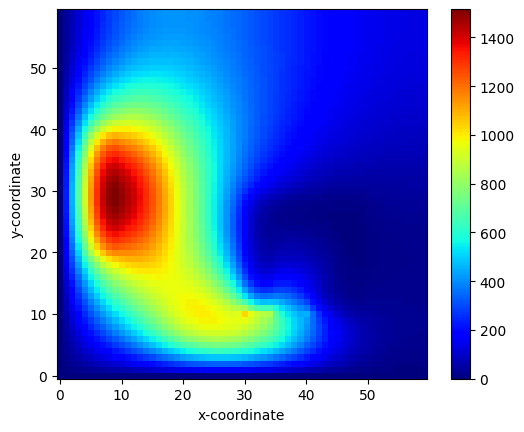

In [6]:
T = np.zeros((2, 60, 60))
probe_values0 = []
probe_values1 = []
probe_values2 = []
probe_values3 = []

start = time()
for it in trange(iterations):
    source(it, T, power, dt)
    source_1(it, T, power, dt)
    diffuse_step_par(it, T, Dij)
    isolation(T)
    probe_values0.append(T[(it+1)%2, 20*scale, 20*scale])
    probe_values1.append(T[(it+1)%2, 40*scale, 20*scale])
    probe_values2.append(T[(it+1)%2, 40*scale, 40*scale])
    probe_values3.append(T[(it+1)%2, 20*scale, 40*scale])
end = time()
np.save('T1.npy', T)
np.save('60probe0.npy',probe_values0)
np.save('60probe1.npy',probe_values1)
np.save('60probe2.npy',probe_values2)
np.save('60probe3.npy',probe_values3)
print(end - start, 's', sep='')
plt.imshow(T[0], cmap = 'jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")

AttributeError: 'list' object has no attribute 'find_peaks'

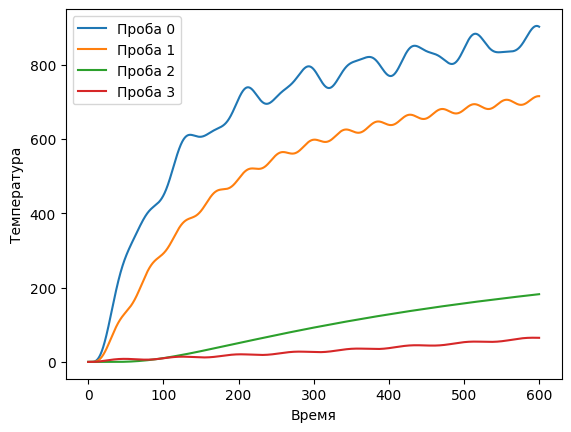

In [18]:
plt.plot(np.arange(iterations) * dt, probe_values0)
plt.plot(np.arange(iterations) * dt, probe_values1)
plt.plot(np.arange(iterations) * dt, probe_values2)
plt.plot(np.arange(iterations) * dt, probe_values3)
plt.xlabel("Время")
plt.ylabel("Температура")
plt.legend(['Проба 0', 'Проба 1', 'Проба 2', 'Проба 3'])
period(probe_values0)

120000


100%|████████████████████████████████| 120000/120000 [00:08<00:00, 13729.91it/s]


8.741412162780762s


Text(0, 0.5, 'y-coordinate')

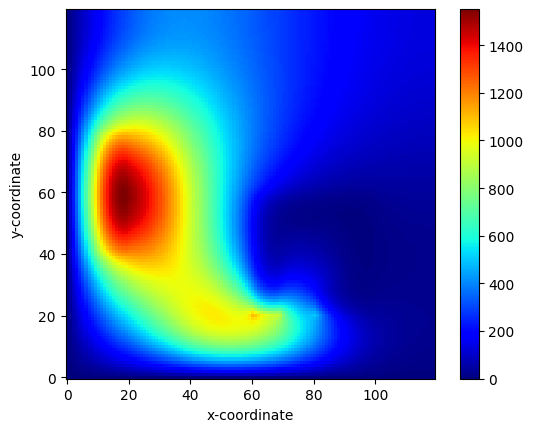

In [22]:
# n1 = 120
# scale1 = n1 // L

Dxy = MatrixD(120, 1.0, 1e-2, 2)

# MAKING SIZES OF HEAT ELEMENT 1
pos = np.array([60, 15], dtype=int)
size = np.array([40, 10], dtype=int)

left = pos[1] - size[1] // 2
right = left + size[1]
bottom = pos[0] - size[0] // 2
top = bottom + size[0]


# MAKING SIZES OF HEAT ELEMENT 2

pos_1 = np.array([15, 60], dtype=int)
size_1 = np.array([10, 40], dtype = int)

left_1 = pos_1[1] - size_1[1] // 2
right_1 = left_1 + size_1[1]
bottom_1 = pos_1[0] - size_1[0] // 2
top_1 = bottom_1 + size_1[0]

iterations = int(max_time / dt)
print(iterations)

T1 = np.zeros((2, 120, 120))

probe_values0 = []
probe_values1 = []
probe_values2 = []
probe_values3 = []

start = time()
for it in trange(iterations):
    source(it, T1, power, dt)
    source_1(it, T1, power, dt)
    diffuse_step_full(it, T1, L / 120, dt, Dxy)
    isolation(T1)
    probe_values0.append(T1[(it+1)%2, 40, 40])
    probe_values1.append(T1[(it+1)%2, 80, 40])
    probe_values2.append(T1[(it+1)%2, 80, 80])
    probe_values3.append(T1[(it+1)%2, 40, 80])
end = time()
np.save('T2.npy', T1)
np.save('120probe0.npy',probe_values0)
np.save('120probe1.npy',probe_values1)
np.save('120probe2.npy',probe_values2)
np.save('120probe3.npy',probe_values3)
print(end - start, 's', sep='')
plt.imshow(T1[0], cmap = 'jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")


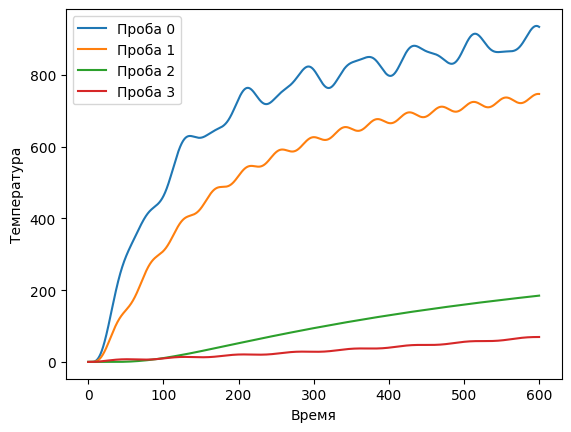

In [23]:
plt.plot(np.arange(iterations) * dt, probe_values0)
plt.plot(np.arange(iterations) * dt, probe_values1)
plt.plot(np.arange(iterations) * dt, probe_values2)
plt.plot(np.arange(iterations) * dt, probe_values3)
plt.xlabel("Время")
plt.ylabel("Температура")
plt.legend(['Проба 0', 'Проба 1', 'Проба 2', 'Проба 3'])

80000


100%|███████████████████████████████████| 80000/80000 [00:20<00:00, 3832.82it/s]

20.873961210250854s


Text(0, 0.5, 'y-coordinate')

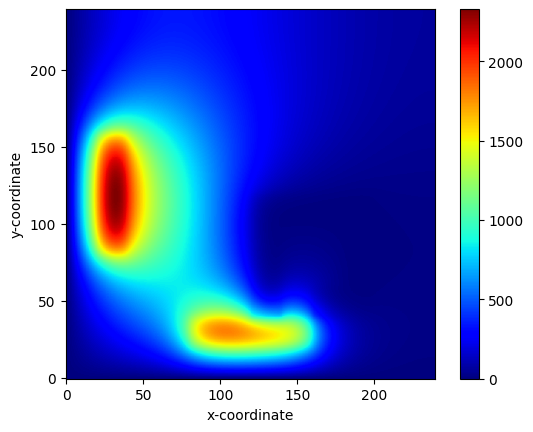

In [24]:
n = 240
scale = n // L
Dij = MatrixD(n, 1.0, 1e-2, scale)
max_time = 400.0
dt = 0.005
# MAKING SIZES OF HEAT ELEMENT 1
pos = np.array([30 *scale, 7.5 *scale], dtype=int)
size = np.array([20 *scale, 5 *scale], dtype=int)

left = pos[1] - size[1] // 2
right = left + size[1]
bottom = pos[0] - size[0] // 2
top = bottom + size[0]


# MAKING SIZES OF HEAT ELEMENT 2

pos_1 = np.array([7.5 *scale, 30 *scale], dtype=int)
size_1 = np.array([5 *scale, 20 *scale], dtype = int)

left_1 = pos_1[1] - size_1[1] // 2
right_1 = left_1 + size_1[1]
bottom_1 = pos_1[0] - size_1[0] // 2
top_1 = bottom_1 + size_1[0]

iterations = int(max_time / dt)
print(iterations)
dt

T = np.zeros((2, n, n))

probe_values0 = []
probe_values1 = []
probe_values2 = []
probe_values3 = []

start = time()
for it in trange(iterations):
    source(it, T, power, dt)
    source_1(it, T, power, dt)
    diffuse_step_full(it, T, L / 240, dt, Dij)
    isolation(T)
    probe_values0.append(T[(it+1)%2, 20*scale, 20*scale])
    probe_values1.append(T[(it+1)%2, 40*scale, 20*scale])
    probe_values2.append(T[(it+1)%2, 40*scale, 40*scale])
    probe_values3.append(T[(it+1)%2, 20*scale, 40*scale])
end = time()
np.save('T3.npy', T)
np.save('240probe0.npy',probe_values0)
np.save('240probe1.npy',probe_values1)
np.save('240probe2.npy',probe_values2)
np.save('240probe3.npy',probe_values3)
print(end - start, 's', sep='')
plt.imshow(T[0], cmap = 'jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")

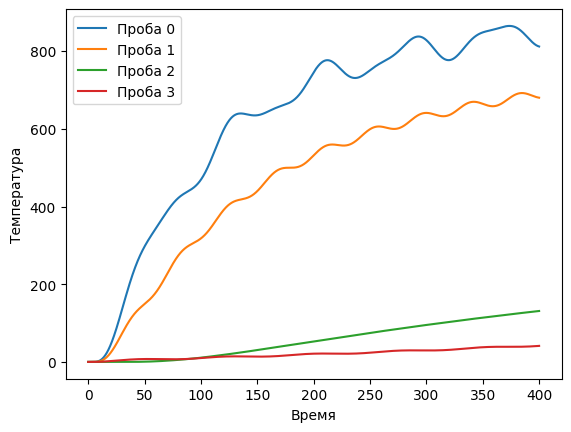

In [25]:
plt.plot(np.arange(iterations) * dt, probe_values0)
plt.plot(np.arange(iterations) * dt, probe_values1)
plt.plot(np.arange(iterations) * dt, probe_values2)
plt.plot(np.arange(iterations) * dt, probe_values3)
plt.xlabel("Время")
plt.ylabel("Температура")
plt.legend(['Проба 0', 'Проба 1', 'Проба 2', 'Проба 3'])

In [26]:
@nb.njit(parallel = True)
def diffuse_step_fast(ti, T, D, N, dt, dx):
    "Функция для рассчета тепла для N = 480, 960. Использую ее, потому что используя diffuse_step_full вылетала ошибка времени вычисления"
    ti = ti % 2
    tj = (ti + 1) % 2
    for i in nb.prange(1, N - 1):
        for j in range(1, N - 1):       
            g = dt * D[i, j] / dx**2
            T[tj, i, j] = T[ti, i, j] + \
                     g * (T[ti, i+1, j] + 
                          T[ti, i-1, j] + 
                          T[ti, i, j+1] + 
                          T[ti, i, j-1] -
                          4 * T[ti, i, j])

200000


100%|█████████████████████████████████| 200000/200000 [00:21<00:00, 9168.17it/s]

21.815999269485474s


Text(0, 0.5, 'y-coordinate')

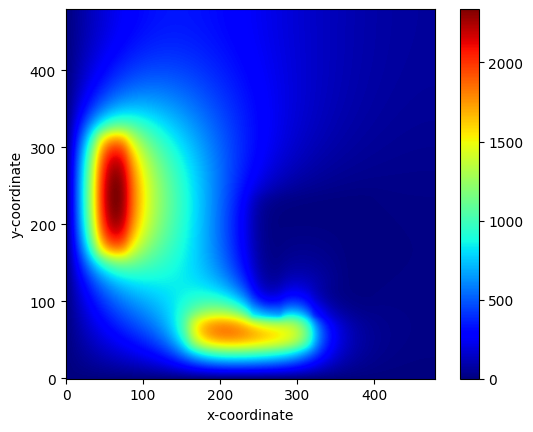

In [32]:
n = 480
scale = n // L
Dij = MatrixD(n, 1.0, 1e-2, scale)
max_time = 400.0
dt = 0.002

# MAKING SIZES OF HEAT ELEMENT 1
pos = np.array([30 *scale, 7.5 *scale], dtype=int)
size = np.array([20 *scale, 5 *scale], dtype=int)

left = pos[1] - size[1] // 2
right = left + size[1]
bottom = pos[0] - size[0] // 2
top = bottom + size[0]


# MAKING SIZES OF HEAT ELEMENT 2

pos_1 = np.array([7.5 *scale, 30 *scale], dtype=int)
size_1 = np.array([5 *scale, 20 *scale], dtype =int)

left_1 = pos_1[1] - size_1[1] // 2
right_1 = left_1 + size_1[1]
bottom_1 = pos_1[0] - size_1[0] // 2
top_1 = bottom_1 + size_1[0]

iterations = int(max_time / dt)
print(iterations)
dt

T = np.zeros((2, n, n))

probe_values01 = []
probe_values11 = []
probe_values21 = []
probe_values31 = []

start = time()
for it in trange(iterations):
    source(it, T, power, dt)
    source_1(it, T, power, dt)
    diffuse_step_fast(it, T, Dij, 480, dt, 0.125)
    isolation(T)
    probe_values01.append(T[(it+1)%2, 20*scale, 20*scale])
    probe_values11.append(T[(it+1)%2, 40*scale, 20*scale])
    probe_values21.append(T[(it+1)%2, 40*scale, 40*scale])
    probe_values31.append(T[(it+1)%2, 20*scale, 40*scale])
end = time()
np.save('T4.npy', T)
np.save('480probe0.npy',probe_values01)
np.save('480probe1.npy',probe_values11)
np.save('480probe2.npy',probe_values21)
np.save('480probe3.npy',probe_values31)
print(end - start, 's', sep='')
plt.imshow(T[0], cmap = 'jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")

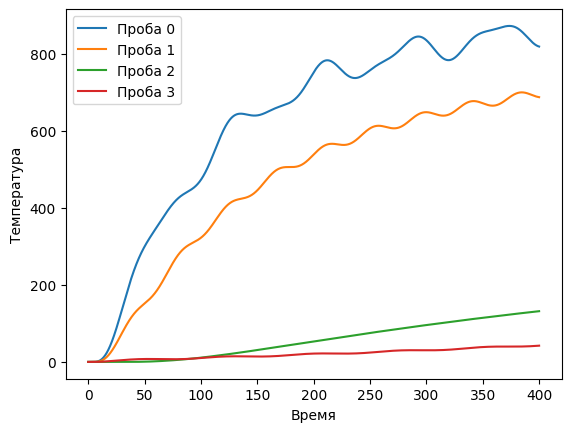

In [33]:
plt.plot(np.arange(iterations) * dt, probe_values01)
plt.plot(np.arange(iterations) * dt, probe_values11)
plt.plot(np.arange(iterations) * dt, probe_values21)
plt.plot(np.arange(iterations) * dt, probe_values31)
plt.xlabel("Время")
plt.ylabel("Температура")
plt.legend(['Проба 0', 'Проба 1', 'Проба 2', 'Проба 3'])

600000


100%|█████████████████████████████████| 600000/600000 [03:43<00:00, 2682.84it/s]


223.64541101455688s


Text(0, 0.5, 'y-coordinate')

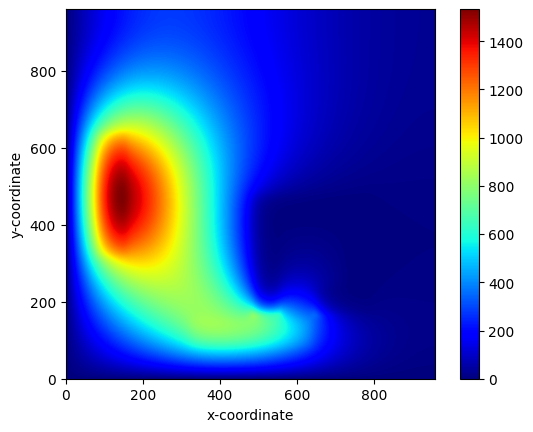

In [34]:
n = 960
scale = n // L
Dij = MatrixD(960, 1.0, 1e-2, scale)
max_time = 300.0
dt = 0.0005

# MAKING SIZES OF HEAT ELEMENT 1
pos = np.array([30 *scale, 7.5 *scale], dtype=int)
size = np.array([20 *scale, 5 *scale], dtype=int)

left = pos[1] - size[1] // 2
right = left + size[1]
bottom = pos[0] - size[0] // 2
top = bottom + size[0]


# MAKING SIZES OF HEAT ELEMENT 2

pos_1 = np.array([7.5 *scale, 30 *scale], dtype=int)
size_1 = np.array([5 *scale, 20 *scale], dtype = int)

left_1 = pos_1[1] - size_1[1] // 2
right_1 = left_1 + size_1[1]
bottom_1 = pos_1[0] - size_1[0] // 2
top_1 = bottom_1 + size_1[0]

iterations = int(max_time / dt)
print(iterations)
dt

T = np.zeros((2, 960, 960))

probe_values0 = []
probe_values1 = []
probe_values2 = []
probe_values3 = []

start = time()
for it in trange(iterations):
    source(it, T, power, dt)
    source_1(it, T, power, dt)
    diffuse_step_fast(it, T, Dij, 960, dt, 0.0625)
    isolation(T)
    probe_values0.append(T[(it+1)%2, 20*scale, 20*scale])
    probe_values1.append(T[(it+1)%2, 40*scale, 20*scale])
    probe_values2.append(T[(it+1)%2, 40*scale, 40*scale])
    probe_values3.append(T[(it+1)%2, 20*scale, 40*scale])
end = time()
np.save('T5.npy', T)
np.save('960probe0.npy',probe_values0)
np.save('960probe1.npy',probe_values1)
np.save('960probe2.npy',probe_values2)
np.save('960probe3.npy',probe_values3)
print(end - start, 's', sep='')
plt.imshow(T[0], cmap = 'jet')
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")

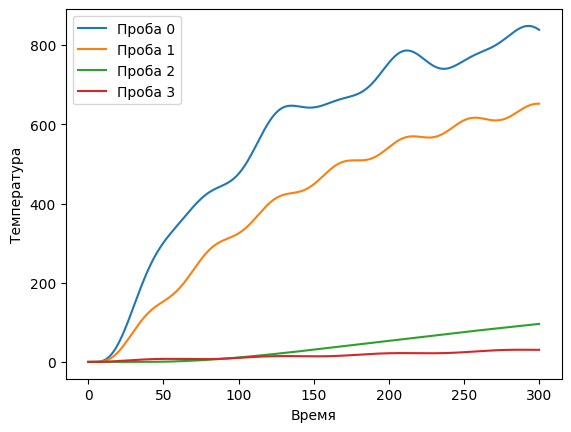

In [35]:
plt.plot(np.arange(iterations) * dt, probe_values0)
plt.plot(np.arange(iterations) * dt, probe_values1)
plt.plot(np.arange(iterations) * dt, probe_values2)
plt.plot(np.arange(iterations) * dt, probe_values3)
plt.xlabel("Время")
plt.ylabel("Температура")
plt.legend(['Проба 0', 'Проба 1', 'Проба 2', 'Проба 3'])